In [1]:
import sys
sys.path.append('..')

import os

import cv2
import numpy as np
import pydicom
import matplotlib.pyplot as plt

from ipywidgets.widgets import interact, IntSlider, fixed
import ipywidgets as widgets

from src.visualisation import PatientSnapshot
from src.segmentation import threshold_segmentation
from src.utils import remove_legs, are_legs

In [10]:
patient_path = '../data/1/'
patient = PatientSnapshot.from_path(patient_path, mask=None)

In [11]:
%%time

patient.snapshot = remove_legs(patient.snapshot)

CPU times: user 16.7 ms, sys: 18.2 ms, total: 34.9 ms
Wall time: 195 ms


In [12]:
%%time

mask = threshold_segmentation(patient.snapshot)
patient.snapshot_mask = mask

CPU times: user 1.26 s, sys: 852 ms, total: 2.11 s
Wall time: 2.14 s


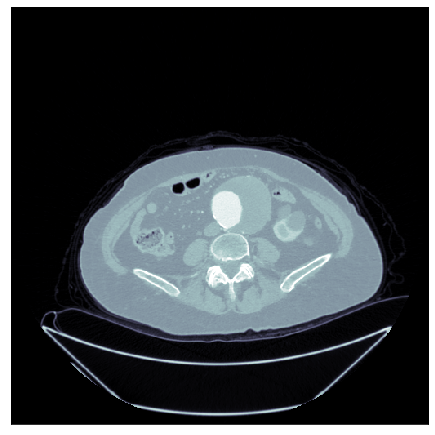

In [13]:
# Static plot
patient.horizontal_plot(z=200, vmin=-1000, vmax=500, plot_mask=True)

In [14]:
# Interactive plot
interact(patient.horizontal_plot, 
         z=IntSlider(min=0, max=patient.shape[0]-1, value=581, continious_update=False), 
         vmin=IntSlider(min=-1000, max=1000, value=-1000, continious_update=False), 
         vmax=IntSlider(min=-1000, max=1000, value=500, continious_update=False),
)

interactive(children=(IntSlider(value=536, description='z', max=536), IntSlider(value=-1000, description='vmin…

<function ipywidgets.widgets.interaction._InteractFactory.__call__.<locals>.<lambda>(*args, **kwargs)>

In [18]:
interact(patient.longitudinal_plot,
        x=IntSlider(min=0, max=patient.shape[2]-1, value=300, continious_update=False),
        vmin=IntSlider(min=-3000, max=3000, value=-1000, continious_update=False) 
        vmax=IntSlider(min=-3000, max=3000, value=500, continious_update=False), 
        plot_mask=True
        )

interactive(children=(IntSlider(value=300, description='x', max=511), IntSlider(value=-1000, description='vmin…

<function ipywidgets.widgets.interaction._InteractFactory.__call__.<locals>.<lambda>(*args, **kwargs)>

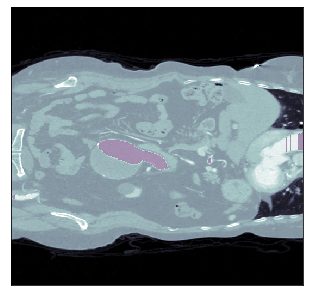

In [8]:
patient.frontal_plot(y=250, vmin=-1000, vmax=500, plot_mask=True)

In [10]:
# threshold = 300
# aspectratio = dict(x=1, y=1, z=1)
# patient.plot_3d(threshold, aspectratio=aspectratio)